<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [32]:
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, ViT_B_16_Weights
import os
import cv2
from collections import Counter

In [3]:
from google.colab import drive

drive.mount('/content/drive')
!tar -xvf drive/MyDrive/cable.tar.gz cable

Mounted at /content/drive
tar: drive/MyDrive/cable.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [4]:
file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW3/bottle/*/*/*.png')
# /content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW3/bottle/ground_truth/broken_large/000_mask.png
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(10)]])

In [5]:
if len(file_paths) == 0:
    print("⚠️ 找不到任何圖片，請檢查資料夾路徑")


In [6]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 900, 900, 3)


Classes: ['content']


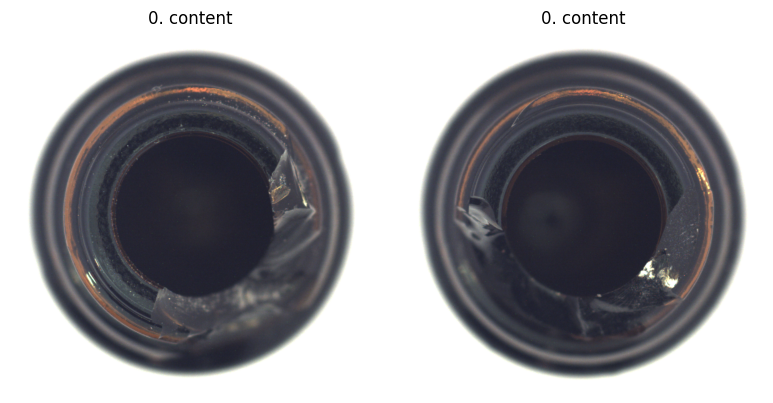

In [7]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('/')[1] for path in file_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(8, 4 * len(classes)))

# 確保 axs 是 2D array（即使只有一行）
if len(classes) == 1:
    axs = np.expand_dims(axs, axis=0)  # axs[1D] -> axs[1][2D]

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


Details of the datatset

In [8]:
#Number of defect classes & Types of defect classes
import os

dataset_path = '/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW3/bottle/test'  # 以bottle為例
defect_classes = [folder for folder in os.listdir(dataset_path) if folder != 'good']
print("Number of defect classes:", len(defect_classes))
print("Types of defect classes:", defect_classes)


Number of defect classes: 3
Types of defect classes: ['contamination', 'broken_small', 'broken_large']


In [9]:
#Number of images used in your dataset
import glob

train_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW3/bottle/train/good/*.png')
test_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW3/bottle/test/*/*.png')

print("Number of training images:", len(train_images))
print("Number of test images:", len(test_images))
print("Total images:", len(train_images) + len(test_images))


Number of training images: 209
Number of test images: 83
Total images: 292


In [10]:
#Distribution of training and test data
from collections import defaultdict

# 計算 test 資料夾中各類別的影像數量
test_distribution = defaultdict(int)
for defect_type in os.listdir('/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW3/bottle/test'):
    images = glob.glob(f'/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW3/bottle/test/{defect_type}/*.png')
    test_distribution[defect_type] = len(images)

print("Test distribution per class:")
for defect_type, count in test_distribution.items():
    print(f"  {defect_type}: {count}")

# 訓練資料通常只有 good
print("Train distribution: good =", len(train_images))


Test distribution per class:
  contamination: 21
  broken_small: 22
  good: 20
  broken_large: 20
Train distribution: good = 209


In [11]:
#Image dimensions
from PIL import Image

sample_image_path = train_images[0]
img = Image.open(sample_image_path)
print("Image size (width x height):", img.size)


Image size (width x height): (900, 900)


## A. Data Loading and Preprocessing

In [33]:
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# ---------- Step 1: Collect image paths and labels ----------

def get_images_by_class(base_path):
    data = []
    labels = []
    class_names = ['good', 'broken_large', 'contamination', 'broken_small']
    label_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        image_paths = glob.glob(f'{base_path}/{class_name}/*.png')
        for path in image_paths:
            data.append(path)
            labels.append(label_map[class_name])

    return data, labels, class_names, label_map

image_paths, image_labels, class_names, label_map = get_images_by_class('/content/drive/MyDrive/Colab Notebooks/NTHU_2025_DLIA_HW/HW3/bottle/test')

# ---------- Step 2: Analyze class distribution ----------

class_counts = Counter(image_labels)
print("Class distribution:", class_counts)

# ---------- Step 3: Split into train and val ----------

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, image_labels, test_size=0.2, stratify=image_labels, random_state=42
)

# ---------- Step 4: Data Augmentation with MixUp ----------

class MixUpTransform:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, batch):
        images, labels = batch
        batch_size = images.size(0)
        lam = np.random.beta(self.alpha, self.alpha, size=(batch_size, 1, 1, 1))
        lam = torch.tensor(lam, dtype=torch.float32, device=images.device)

        indices = torch.randperm(batch_size, device=images.device)

        mixed_images = lam * images + (1 - lam) * images[indices]
        return mixed_images, labels, labels[indices], lam.squeeze()


# ---------- Step 5: Advanced Dataset with Augmentation ----------

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    # Add more augmentations
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.05),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Add random erasing for occlusion robustness
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# ---------- Step 6: Create DataLoaders with Weighted Sampling ----------

train_dataset = ImageDataset(train_paths, train_labels, transform=transform_train)
val_dataset = ImageDataset(val_paths, val_labels, transform=transform_val)

# Calculate class weights for balanced sampling
class_weights = [1.0 / class_counts[i] for i in range(len(class_names))]
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


Class distribution: Counter({3: 22, 2: 21, 0: 20, 1: 20})


## B. Defining Neural Networks

In [34]:
# Vision Transformer with custom head

class ViTBottleClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ViTBottleClassifier, self).__init__()
        # Load pre-trained ViT model
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

        # Freeze most layers except the last few
        for param in list(self.vit.parameters())[:-20]:  # Keep last few layers trainable
            param.requires_grad = False

        # Replace the head
        self.vit.heads = nn.Sequential(
            nn.Linear(self.vit.hidden_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.vit(x)

# Initialize the model
model = ViTBottleClassifier(num_classes=4)

# Define MixUp Loss

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    if len(lam.shape) == 0:
        # scalar lam
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    else:
        # vector lam
        loss_a = criterion(pred, y_a)
        loss_b = criterion(pred, y_b)
        return (lam * loss_a + (1 - lam) * loss_b).mean()


## C. Training the Neural Network

In [35]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
mixup = MixUpTransform(alpha=0.2)  # MixUp transform

best_val_loss = float('inf')
best_val_acc = -1

# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion = FocalLoss(gamma=2)
base_criterion = nn.CrossEntropyLoss()

# One Cycle learning rate scheduler for better convergence
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.1)

# Training loop with MixUp augmentation
for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Apply MixUp with 50% probability
        if np.random.random() > 0.5:
            mixed_images, labels_a, labels_b, lam = mixup((images, labels))

            optimizer.zero_grad()
            outputs = model(mixed_images)

            # Mixed loss
            loss = mixup_criterion(base_criterion, outputs, labels_a, labels_b, lam)
        else:
            optimizer.zero_grad()
            outputs = model(images)

            # Standard loss
            loss = criterion(outputs, labels)

            # For accuracy calculation
            train_predicted = outputs.argmax(-1)
            train_correct += (train_predicted == labels).sum().item()
            total_train_samples += labels.size(0)

        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples if total_train_samples > 0 else 0

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = base_criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Checkpoint
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'approach4_vit.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val acc: {best_val_acc:.2f}%')

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.7657, Train acc: 32.00%, Val loss: 1.4068, Val acc: 35.29%, Best Val acc: 35.29%
Epoch 2/30, Train loss: 1.3342, Train acc: 0.00%, Val loss: 1.5897, Val acc: 29.41%, Best Val acc: 35.29%
Epoch 3/30, Train loss: 1.3120, Train acc: 31.25%, Val loss: 1.2722, Val acc: 47.06%, Best Val acc: 47.06%
Epoch 4/30, Train loss: 0.9324, Train acc: 32.35%, Val loss: 1.1961, Val acc: 41.18%, Best Val acc: 47.06%
Epoch 5/30, Train loss: 0.6865, Train acc: 57.81%, Val loss: 1.1834, Val acc: 35.29%, Best Val acc: 47.06%
Epoch 6/30, Train loss: 0.9969, Train acc: 75.00%, Val loss: 0.8610, Val acc: 70.59%, Best Val acc: 70.59%
Epoch 7/30, Train loss: 0.4779, Train acc: 72.92%, Val loss: 1.0607, Val acc: 41.18%, Best Val acc: 70.59%
Epoch 8/30, Train loss: 0.8369, Train acc: 72.22%, Val loss: 0.6741, Val acc: 70.59%, Best Val acc: 70.59%
Epoch 9/30, Train loss: 0.5102, Train acc: 72.92%, Val loss: 0.6237, Val acc: 64.71%, Best Val acc: 70.59%
Epoch 10/30, Train loss: 0.7458, Train

### Visualizing model performance

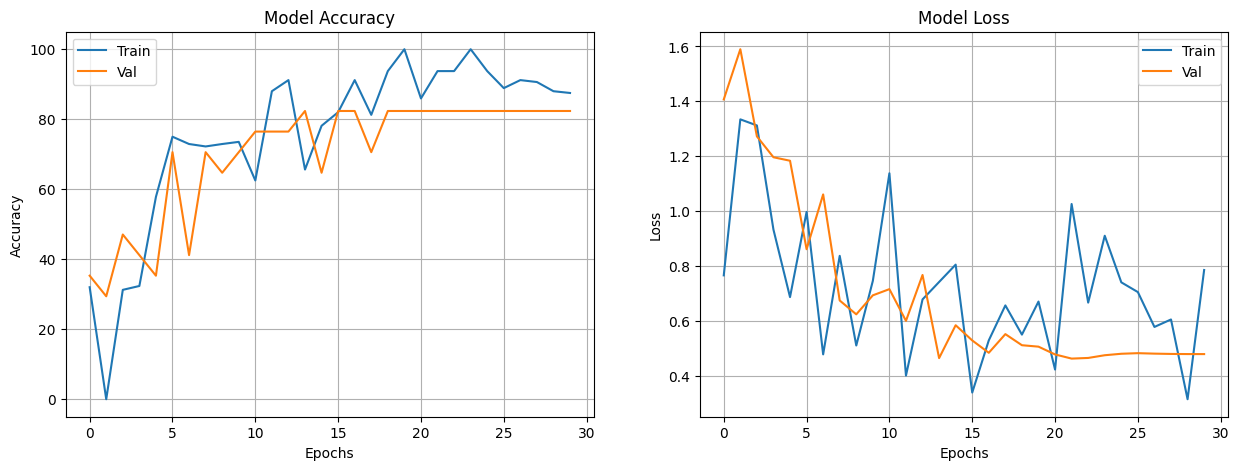

In [36]:
import matplotlib.pyplot as plt

# Plot losses and accuracies
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])
ax[0].grid(True)

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])
ax[1].grid(True)

plt.savefig('approach4_training_curves.png')
plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

Overall Test Accuracy: 82.35%
Accuracy of good: 100.00%
Accuracy of broken_large: 50.00%
Accuracy of contamination: 75.00%
Accuracy of broken_small: 100.00%


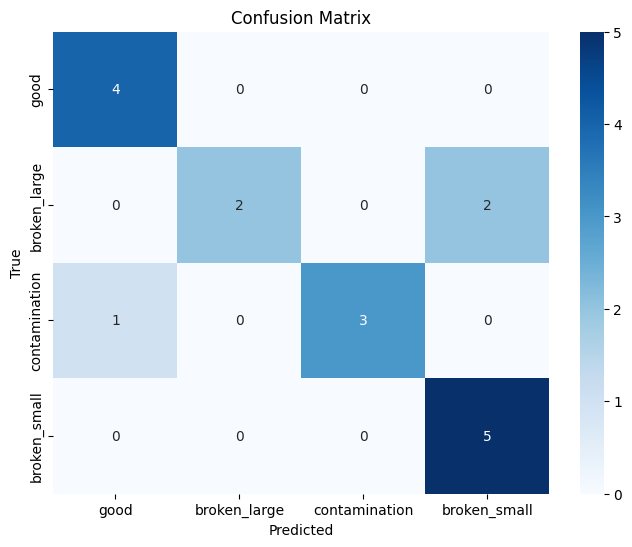

Classification Report:
               precision    recall  f1-score   support

         good       0.80      1.00      0.89         4
 broken_large       1.00      0.50      0.67         4
contamination       1.00      0.75      0.86         4
 broken_small       0.71      1.00      0.83         5

     accuracy                           0.82        17
    macro avg       0.88      0.81      0.81        17
 weighted avg       0.87      0.82      0.81        17



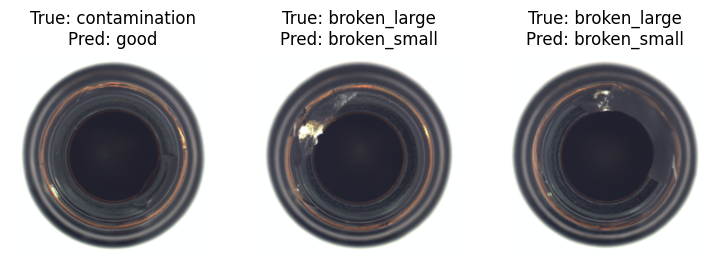

In [37]:
# Load the best model
model.load_state_dict(torch.load('approach4_vit.pth'))
model.eval()

test_correct = 0
test_total = 0
class_correct = [0] * 4
class_total = [0] * 4
all_preds = []
all_labels = []
misclassified_examples = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = outputs.argmax(-1)

        # Store predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Track misclassified examples
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_examples.append({
                    'image': images[i].cpu(),
                    'true': labels[i].item(),
                    'pred': predicted[i].item()
                })

        # Overall accuracy
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        # Per-class accuracy
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

print(f'Overall Test Accuracy: {100. * test_correct / test_total:.2f}%')
for i in range(4):
    class_name = class_names[i]
    class_acc = 100. * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Accuracy of {class_name}: {class_acc:.2f}%')

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('approach4_confusion_matrix.png')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Visualize some misclassified examples
if misclassified_examples:
    n_examples = min(5, len(misclassified_examples))
    fig, axs = plt.subplots(1, n_examples, figsize=(n_examples*3, 3))

    for i in range(n_examples):
        example = misclassified_examples[i]
        img = example['image'].permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        if n_examples == 1:
            axs.imshow(img)
            axs.set_title(f"True: {class_names[example['true']]}\nPred: {class_names[example['pred']]}")
            axs.axis('off')
        else:
            axs[i].imshow(img)
            axs[i].set_title(f"True: {class_names[example['true']]}\nPred: {class_names[example['pred']]}")
            axs[i].axis('off')

    plt.savefig('approach4_misclassified.png')
    plt.show()